<a href="https://colab.research.google.com/github/jacquelinechan09/Computer-Vision-in-Python/blob/main/Computer_Vision_using_Python_Gaussian_Pyramids%2C_Facial_Detection_and_Image_Blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computer Vision using Python: Gaussian Pyramids, Facial Detection and Image Blurring

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import ncc     

from scipy import signal, ndimage
from IPython.display import Image as ImageIPy 
from IPython.display import display

In [ ]:
def MakeGaussianPyramid(image, scale, minsize):
    pyramid = [] # initialize an empty array for the pyramid
    original_Duplicate = image.copy(); # create a duplicate of the original image
    grayscale_or_colour = original_Duplicate.mode; # get whether the image is black-and-white, or in colour
    w,h = original_Duplicate.size; # obtain the height, width of the original picture (via the duplicated image created two lines above)
    while max(w,h) >= minsize: # loop over the following code, but only when the longest of the width & height are larger than, or equal to the inputted minimum restriction (i.e. minsize)
        h = int(scale * h) # multiply the inputted scaling factor by the current height in order to get the new height
        w = int(scale * w) # multiply the inputted scaling factor by the current width in order to get the new width
        array_numpy = (np.asarray(original_Duplicate)).copy(); # the original array is made into a numpy array
        if max(w, h) >= minsize: # if the maximum of the width & height is greater than the inputted minimum size (i.e. minsize)
            array_zeros = np.zeros(array_numpy.shape) # convert the numpy array (i.e. array_numpy) into an array filled with zeros
            if grayscale_or_colour is "RGB":
              for i in range(0, array_numpy.shape[2]): # for 'RGB', every channel is filtered separately
                    array_zeros[:,:,i] = ndimage.gaussian_filter(array_numpy[:,:,i], scale * (2**(-1))); # apply the Gaussian filter to the separated channels
            else: # for 'L', no need to separate into channels, just apply the Gaussian filter below
                array_zeros = ndimage.gaussian_filter(array_numpy, scale * (2**(-1)));
            filtering = Image.fromarray(array_zeros, mode=grayscale_or_colour); # obtain the image from the array
            original_Duplicate = filtering.resize((w,h)); # update the image after resizing           
        pyramid.append(array_numpy); # add the newly-created numpy array into the pyramid array
    return pyramid # return the filled pyramid array

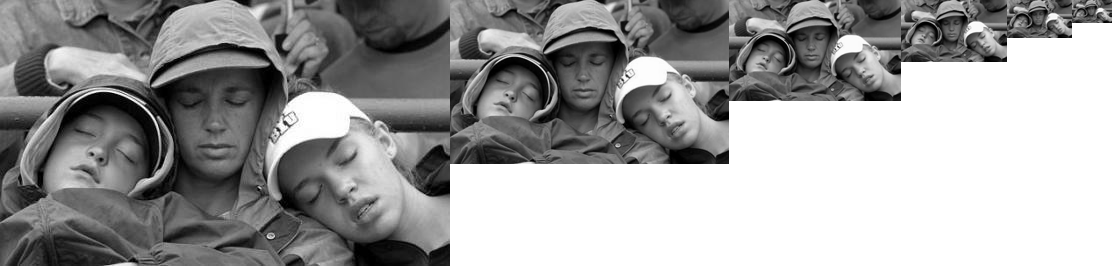

In [ ]:
def ShowGaussianPyramid(pyramid):
  vert = 0; # this value is to be used in the for-loop of this function, it is the vertical offset of the picture
  horz = 0; # this value is to be used in the for-loop of this function, it is the horizontal offset of the picture
  h = pyramid[0].shape[0]; # initialize the height
  w = 0; # initialize the width to 0
  for array_numpy in pyramid: # update the width as follows
    w += array_numpy.shape[1];
  if pyramid[0].ndim != 3:
    grayscale_or_colour = 'L'; # the image is black-and-white if the number of dimensions is not 3 (the array is not 3-dimensional)
    img_layout = Image.new(grayscale_or_colour, (w,h), color='white'); # generate a new grayscale image
  else:
    grayscale_or_colour = 'RGB'; # otherwise set the image to RGB
    img_layout = Image.new('RGB', (w,h), color='white'); # generate a new coloured image
  for array_numpy in pyramid:
    picture = Image.fromarray(array_numpy); # obtain the image from the array
    img_layout.paste(picture, (horz, vert)); # lay out the image with the vertical and horizontal offsets included
    horz += picture.size[0];
  img_layout.save('showGaussianPyramidImage.png', 'png') # save the Gaussian pyramid image
  display(ImageIPy(filename='showGaussianPyramidImage.png')) # display the Gaussian pyramid image
  return;
  
test_img = Image.open('fans.jpg'); # using the provided fans.jpg image to test my functions in questions 2 and 3
pyramid = MakeGaussianPyramid(test_img, 0.62, 35); # first, use the function in question 2 to generate the Gaussian pyramid
ShowGaussianPyramid(pyramid); # finally, use the function in this question (q3) to display the Gaussian pyramid image

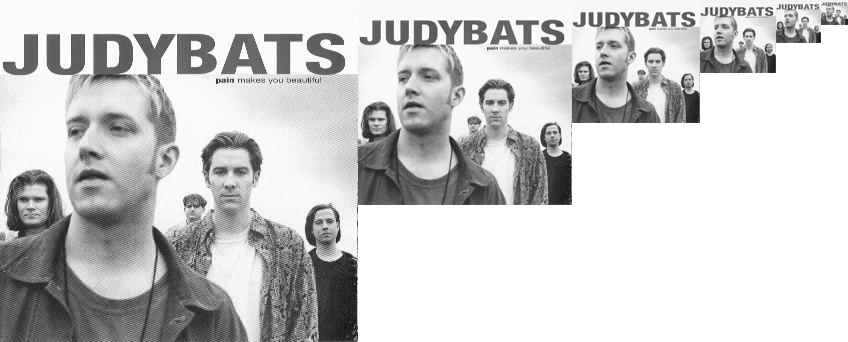

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


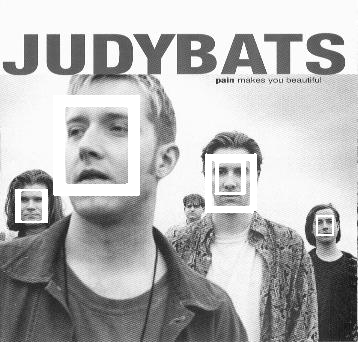

In [ ]:
def colourChange(picArr, pyImg):
    picture = Image.fromarray(picArr); # obtain the image from the array
    applyResize = picture.resize((pyImg.shape[1], pyImg.shape[0])); # resize the image accordingly
    for i in range(0, pyImg.shape[0]): # use 'i' for the rows, and loop over values from 0 until 'pyImg.shape[0]'
        for j in range(0, pyImg.shape[1]): # use 'j' for the columns, and loop over values from 0 until 'pyImg.shape[1]'
            if applyResize.getpixel((j, i)) >= 200:
               pyImg[i, j] = 255; # changes the selection to be of colour white, if by the >= 200, it is evident that such location is to be bounded
    return
   
def surroundings(templ_area, pic_area, selection):
    firstSurroundingCoord = [0, 0]; # initialize four surrounding points, each with the value [0, 0]
    secondSurroundingCoord = [0, 0];
    thirdSurroundingCoord = [0, 0];
    fourthSurroundingCoord = [0, 0];
    templ_w, templ_h = templ_area; # the template's area = width x height
    pic_w, pic_h = pic_area; # the pic's area = width x height
    firstSurroundingCoord[1] = secondSurroundingCoord[1] = -templ_h/2 + selection[1]; # calculate the coordinates
    thirdSurroundingCoord[1] = fourthSurroundingCoord[1] = templ_h + firstSurroundingCoord[1];  
    firstSurroundingCoord[0] = fourthSurroundingCoord[0] = -templ_w/2 + selection[0];
    secondSurroundingCoord[0] = thirdSurroundingCoord[0] = templ_w + firstSurroundingCoord[0];
    return (firstSurroundingCoord, secondSurroundingCoord, thirdSurroundingCoord, fourthSurroundingCoord) # return the updated coordinates

def helperDraw(pic, templ_area, greaterThanThreshold):
    pic_w, pic_h = pic.size; # size of the picture, also equal to (picture width) * (picture height)
    npArrayZeros = np.zeros((pic.size[1], pic.size[0])); # create a numpy array of zeros
    obtainedpic = Image.fromarray(npArrayZeros); # obtain the image from the previously-created array
    draw = ImageDraw.Draw(obtainedpic); # initialize the variable 'draw'
    for i in range(0, pic_h): # loop over the i-values (i.e. rows) from 0 to the picture's height
        for j in range(0, pic_w): # loop over the j-values (i.e. columns) from 0 to the picture's width
          if greaterThanThreshold[i, j] == 1: # draw the lines if this condition is met
            obtainedCoords = surroundings(templ_area, pic.size, (j, i)); # use my previous helper function to locate the coordinates
            firstSurroundingCoord, secondSurroundingCoord, thirdSurroundingCoord, fourthSurroundingCoord = obtainedCoords; # draw the lines below
            draw.line((firstSurroundingCoord[0], firstSurroundingCoord[1], secondSurroundingCoord[0], secondSurroundingCoord[1]),fill=255,width=2); # top border is drawn
            draw.line((fourthSurroundingCoord[0],fourthSurroundingCoord[1],firstSurroundingCoord[0],firstSurroundingCoord[1]),fill=255,width=2); # left border is drawn
            draw.line((secondSurroundingCoord[0],secondSurroundingCoord[1],thirdSurroundingCoord[0],thirdSurroundingCoord[1]),fill=255,width=2); # right border is drawn
            draw.line((thirdSurroundingCoord[0],thirdSurroundingCoord[1],fourthSurroundingCoord[0],fourthSurroundingCoord[1]),fill=255,width=2); # bottom border is drawn
    npArrayZeros = (np.asarray(obtainedpic)); # convert the obtained picture into a numpy array, and have this function use that as its return value
    return npArrayZeros

def FindTemplate(pyramid, template, threshold): # mark locations in the pyramid where the [template's NCC with the image] > [threshold]
    retvalRepresentingSum = 0; # initialize this to 0
    pyImg = Image.fromarray(pyramid[0]); # obtain the image from the array
    pyImg = (np.asarray(pyImg)).copy();
    for pic in pyramid: # loop over
        picImg = Image.fromarray(pic); # obtain the picture from the array 
        templateImg = Image.fromarray(template) # obtain the template image from the array
        normxcorrArr = ncc.normxcorr2D(picImg, templateImg); # Normalized 2-D cross-correlation
        greaterThanThreshold = threshold < normxcorrArr; # compare against the threshold to see if the NCC is larger
        picArr = helperDraw(picImg, templateImg.size, greaterThanThreshold) # call my helper function(helperDraw) when NCC is greater than threshold
        retvalRepresentingSum += np.sum(greaterThanThreshold) # sum up values larger than the threshold, and have this function return this sum
        colourChange(picArr, pyImg) # call my colourChange helper to change such pixels to colour 255 (white)
    return (pyImg, retvalRepresentingSum) # return the pyramid image and the sum of NCC values greater than the threshold

# use the judybats image to test my functions
templ_w = 15; # temp_w is a constant for template width, reduce it to 15 pixels
faceDetectTemplate = Image.open('face_detection_template.jpg');
changeWidth = (templ_w)*(faceDetectTemplate.size[0])**(-1);
changeSize = faceDetectTemplate.resize((templ_w, int(changeWidth*faceDetectTemplate.size[1])), Image.BICUBIC); # resize the face detection template
arrayOfChangeSize = (np.asarray(changeSize)).copy() # convert into a numpy array
judybats = Image.open('judybats.jpg');
judybats_with_pyramidfxn_applied = MakeGaussianPyramid(judybats, 0.6, 25);
ShowGaussianPyramid(judybats_with_pyramidfxn_applied);
variableForChangingThreshold = 0.592; # change the threshold here, for the FindTemplate function
judybatsImageArray, _ = FindTemplate(judybats_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
judybatsUpdatedImage = Image.fromarray(judybatsImageArray); # obtain the image from the array
judybatsUpdatedImage.save('judybatsWithEdits.png', 'png')
display(ImageIPy(filename='judybatsWithEdits.png'))

With the threshold chosen as 0.57, all 6 pictures totaled have the # of false positives fairly close to the # of false negatives -- Number of non-faces seen as faces is 12; number of missed faces is 14. My work is shown below.

/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


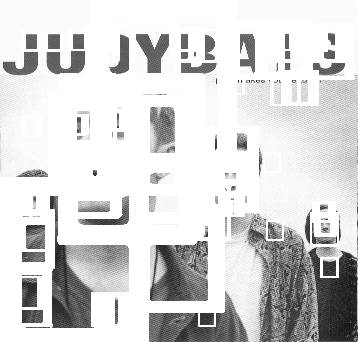

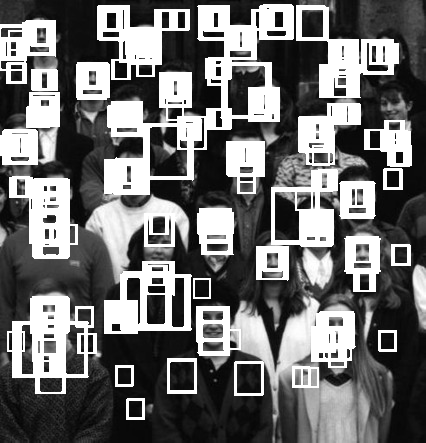

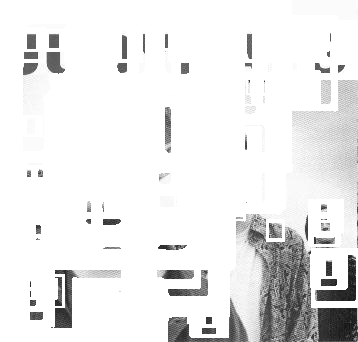

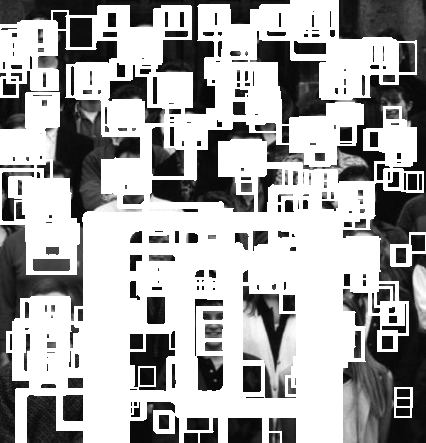

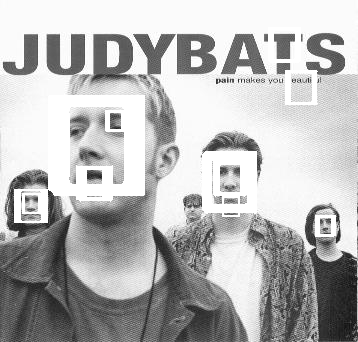

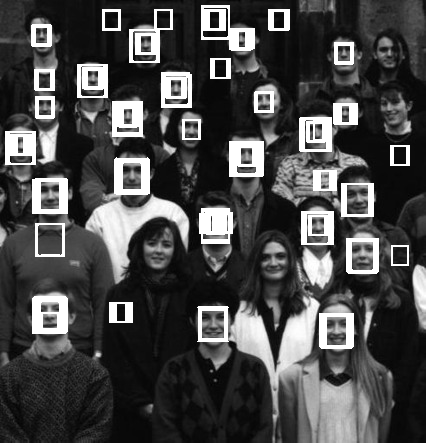

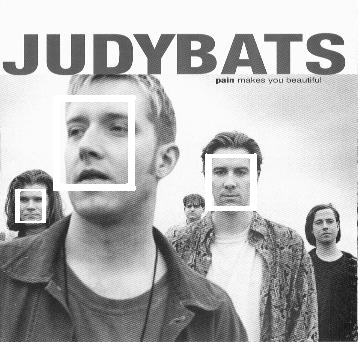

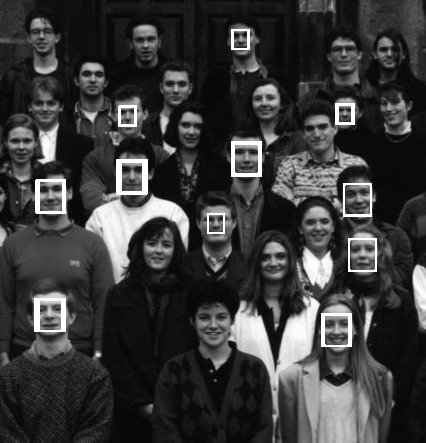

In [ ]:
# finding an ideal threshold via experimentation:

variableForChangingThreshold = 0.4  # evidently, there are many more false positives with 0.4

templ_w = 15; # temp_w is a constant for template width, reduce it to 15 pixels
faceDetectTemplate = Image.open('face_detection_template.jpg');
changeWidth = (templ_w)*(faceDetectTemplate.size[0])**(-1);
changeSize = faceDetectTemplate.resize((templ_w, int(changeWidth*faceDetectTemplate.size[1])), Image.BICUBIC); # resize the face detection template
arrayOfChangeSize = (np.asarray(changeSize)).copy() # convert into a numpy array

judybats = Image.open('judybats.jpg');
judybats_with_pyramidfxn_applied = MakeGaussianPyramid(judybats, 0.6, 25);
judybatsImageArray, _ = FindTemplate(judybats_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
judybatsUpdatedImage = Image.fromarray(judybatsImageArray); # obtain the image from the array
judybatsUpdatedImage.save('judybatsWithEdits.png', 'png')
display(ImageIPy(filename='judybatsWithEdits.png'))

students = Image.open('students.jpg');
students_with_pyramidfxn_applied = MakeGaussianPyramid(students, 0.6, 25);
studentsImageArray, _ = FindTemplate(students_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
studentsUpdatedImage = Image.fromarray(studentsImageArray); # obtain the image from the array
studentsUpdatedImage.save('studentsWithEdits.png', 'png')
display(ImageIPy(filename='studentsWithEdits.png'))

variableForChangingThreshold = 0.35  # even more false positives with 0.35 (compared to 0.4)! Hence, this threshold value must be increased.

templ_w = 15; # temp_w is a constant for template width, reduce it to 15 pixels
faceDetectTemplate = Image.open('face_detection_template.jpg');
changeWidth = (templ_w)*(faceDetectTemplate.size[0])**(-1);
changeSize = faceDetectTemplate.resize((templ_w, int(changeWidth*faceDetectTemplate.size[1])), Image.BICUBIC); # resize the face detection template
arrayOfChangeSize = (np.asarray(changeSize)).copy() # convert into a numpy array

judybats = Image.open('judybats.jpg');
judybats_with_pyramidfxn_applied = MakeGaussianPyramid(judybats, 0.6, 25);
judybatsImageArray, _ = FindTemplate(judybats_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
judybatsUpdatedImage = Image.fromarray(judybatsImageArray); # obtain the image from the array
judybatsUpdatedImage.save('judybatsWithEdits.png', 'png')
display(ImageIPy(filename='judybatsWithEdits.png'))

students = Image.open('students.jpg');
students_with_pyramidfxn_applied = MakeGaussianPyramid(students, 0.6, 25);
studentsImageArray, _ = FindTemplate(students_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
studentsUpdatedImage = Image.fromarray(studentsImageArray); # obtain the image from the array
studentsUpdatedImage.save('studentsWithEdits.png', 'png')
display(ImageIPy(filename='studentsWithEdits.png'))

variableForChangingThreshold = 0.5  # that's better, though the threshold should still be increased... (still more false positives than negatives... unequal error rate)

templ_w = 15; # temp_w is a constant for template width, reduce it to 15 pixels
faceDetectTemplate = Image.open('face_detection_template.jpg');
changeWidth = (templ_w)*(faceDetectTemplate.size[0])**(-1);
changeSize = faceDetectTemplate.resize((templ_w, int(changeWidth*faceDetectTemplate.size[1])), Image.BICUBIC); # resize the face detection template
arrayOfChangeSize = (np.asarray(changeSize)).copy() # convert into a numpy array

judybats = Image.open('judybats.jpg');
judybats_with_pyramidfxn_applied = MakeGaussianPyramid(judybats, 0.6, 25);
judybatsImageArray, _ = FindTemplate(judybats_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
judybatsUpdatedImage = Image.fromarray(judybatsImageArray); # obtain the image from the array
judybatsUpdatedImage.save('judybatsWithEdits.png', 'png')
display(ImageIPy(filename='judybatsWithEdits.png'))

students = Image.open('students.jpg');
students_with_pyramidfxn_applied = MakeGaussianPyramid(students, 0.6, 25);
studentsImageArray, _ = FindTemplate(students_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
studentsUpdatedImage = Image.fromarray(studentsImageArray); # obtain the image from the array
studentsUpdatedImage.save('studentsWithEdits.png', 'png')
display(ImageIPy(filename='studentsWithEdits.png'))

variableForChangingThreshold = 0.65  # need to decrease now

templ_w = 15; # temp_w is a constant for template width, reduce it to 15 pixels
faceDetectTemplate = Image.open('face_detection_template.jpg');
changeWidth = (templ_w)*(faceDetectTemplate.size[0])**(-1);
changeSize = faceDetectTemplate.resize((templ_w, int(changeWidth*faceDetectTemplate.size[1])), Image.BICUBIC); # resize the face detection template
arrayOfChangeSize = (np.asarray(changeSize)).copy() # convert into a numpy array

judybats = Image.open('judybats.jpg');
judybats_with_pyramidfxn_applied = MakeGaussianPyramid(judybats, 0.6, 25);
judybatsImageArray, _ = FindTemplate(judybats_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
judybatsUpdatedImage = Image.fromarray(judybatsImageArray); # obtain the image from the array
judybatsUpdatedImage.save('judybatsWithEdits.png', 'png')
display(ImageIPy(filename='judybatsWithEdits.png'))

students = Image.open('students.jpg');
students_with_pyramidfxn_applied = MakeGaussianPyramid(students, 0.6, 25);
studentsImageArray, _ = FindTemplate(students_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
studentsUpdatedImage = Image.fromarray(studentsImageArray); # obtain the image from the array
studentsUpdatedImage.save('studentsWithEdits.png', 'png')
display(ImageIPy(filename='studentsWithEdits.png'))


/content/ncc.py:59: RuntimeWarning: divide by zero encountered in true_divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


Judybats -- Number of non-faces seen as faces is 1; number of missed faces is 1.


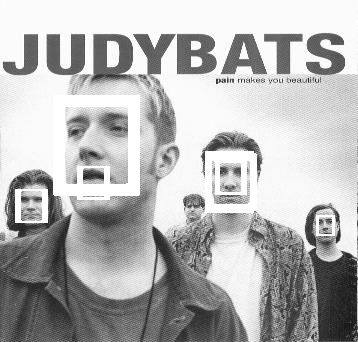

Students -- Number of non-faces seen as faces is 5; number of missed faces is 7.


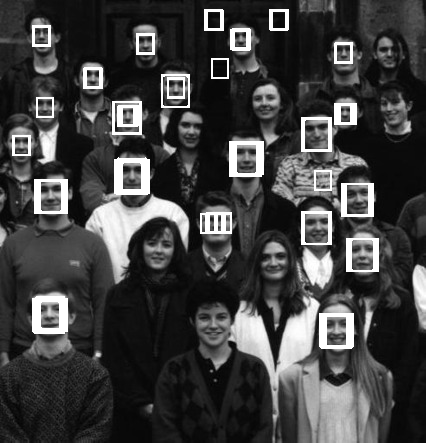

Tree -- Number of non-faces seen as faces is 3; number of missed faces is 0.


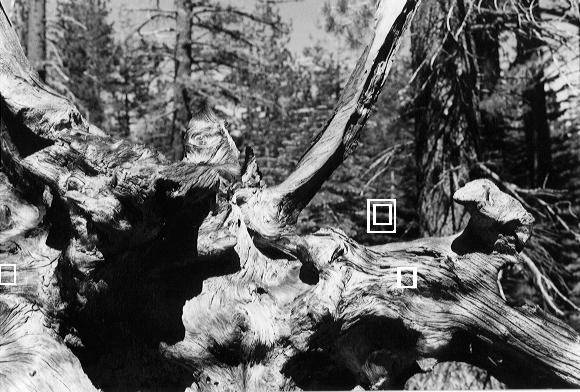

Family -- Number of non-faces seen as faces is 0; number of missed faces is 2.


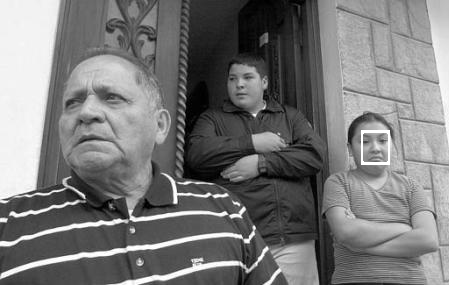

Fans -- Number of non-faces seen as faces is 3; number of missed faces is 3.


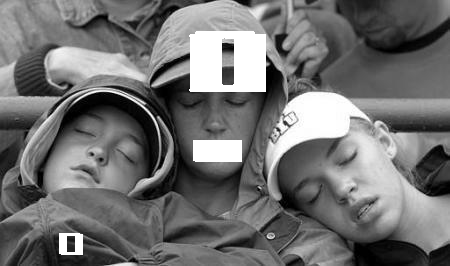

Sports -- Number of non-faces seen as faces is 0; number of missed faces is 1.


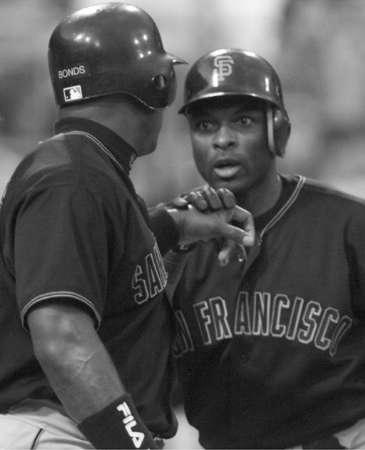

In [ ]:
# using the ideal threshold:

variableForChangingThreshold = 0.57  # this is pretty ideal, more suitable than the previous tests

templ_w = 15; # temp_w is a constant for template width, reduce it to 15 pixels
faceDetectTemplate = Image.open('face_detection_template.jpg');
changeWidth = (templ_w)*(faceDetectTemplate.size[0])**(-1);
changeSize = faceDetectTemplate.resize((templ_w, int(changeWidth*faceDetectTemplate.size[1])), Image.BICUBIC); # resize the face detection template
arrayOfChangeSize = (np.asarray(changeSize)).copy() # convert into a numpy array

judybats = Image.open('judybats.jpg');
judybats_with_pyramidfxn_applied = MakeGaussianPyramid(judybats, 0.6, 25);
judybatsImageArray, _ = FindTemplate(judybats_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
judybatsUpdatedImage = Image.fromarray(judybatsImageArray); # obtain the image from the array
judybatsUpdatedImage.save('judybatsWithEdits.png', 'png')
print(f"Judybats -- Number of non-faces seen as faces is 1; number of missed faces is 1.")
display(ImageIPy(filename='judybatsWithEdits.png'))

students = Image.open('students.jpg');
students_with_pyramidfxn_applied = MakeGaussianPyramid(students, 0.6, 25);
studentsImageArray, _ = FindTemplate(students_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
studentsUpdatedImage = Image.fromarray(studentsImageArray); # obtain the image from the array
studentsUpdatedImage.save('studentsWithEdits.png', 'png')
print(f"Students -- Number of non-faces seen as faces is 5; number of missed faces is 7.")
display(ImageIPy(filename='studentsWithEdits.png'))

tree = Image.open('tree.jpg');
tree_with_pyramidfxn_applied = MakeGaussianPyramid(tree, 0.6, 25);
treeImageArray, _ = FindTemplate(tree_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
treeUpdatedImage = Image.fromarray(treeImageArray); # obtain the image from the array
treeUpdatedImage.save('treeWithEdits.png', 'png')
print(f"Tree -- Number of non-faces seen as faces is 3; number of missed faces is 0.")
display(ImageIPy(filename='treeWithEdits.png'))

family = Image.open('family.jpg');
family_with_pyramidfxn_applied = MakeGaussianPyramid(family, 0.6, 25);
familyImageArray, _ = FindTemplate(family_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
familyUpdatedImage = Image.fromarray(familyImageArray); # obtain the image from the array
familyUpdatedImage.save('familyWithEdits.png', 'png')
print(f"Family -- Number of non-faces seen as faces is 0; number of missed faces is 2.")
display(ImageIPy(filename='familyWithEdits.png'))

fans = Image.open('fans.jpg');
fans_with_pyramidfxn_applied = MakeGaussianPyramid(fans, 0.6, 25);
fansImageArray, _ = FindTemplate(fans_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
fansUpdatedImage = Image.fromarray(fansImageArray); # obtain the image from the array
fansUpdatedImage.save('fansWithEdits.png', 'png')
print(f"Fans -- Number of non-faces seen as faces is 3; number of missed faces is 3.")
display(ImageIPy(filename='fansWithEdits.png'))

sports = Image.open('sports.jpg');
sports_with_pyramidfxn_applied = MakeGaussianPyramid(sports, 0.6, 25);
sportsImageArray, _ = FindTemplate(sports_with_pyramidfxn_applied, arrayOfChangeSize, variableForChangingThreshold); # use the FindTemplate function
sportsUpdatedImage = Image.fromarray(sportsImageArray); # obtain the image from the array
sportsUpdatedImage.save('sportsWithEdits.png', 'png')
print(f"Sports -- Number of non-faces seen as faces is 0; number of missed faces is 1.")
display(ImageIPy(filename='sportsWithEdits.png'))

The recall rate is defined as: (tp)/(tp + fn), where tp represents true positive, and fn represents false negative. 

Judybats: 4/(4 + 1) = 0.8. The number 4 is used because four faces were both present and correctly detected. As for the 1, there was one other face present that was not detected.

Students: 20/(20 + 7) = 0.74. The number 20 is used because twenty faces were both present and correctly detected. As for the 7, there were seven other faces present that were not detected.

Tree: 0/(0 + 0) = 0. There were no faces in this image.

Family: 1/(1 + 2) = 0.33. The number 1 is used because one face was both present and correctly detected. As for the 2, there were two other faces present that were not detected.

Fans: 0/(0 + 3) = 0. Three faces were in this picture, and all three were not detected.

Sports: 0/(0 + 1) = 0. One face (back of the person's head does not count) was present and not detected. 
______________________

The NCC method has a very-low recall rate on some images because there are no true positives detected in them (hence the recall rate must be zero in such situations). If the face is partially blocked (by a helmet or cap in 'Fans' and 'Sports', for example) or shown at an angle, then it is harder to be correctly detected. In addition, the helmets/caps in 'Fans' and 'Sports' also changes the brightness: with reduced brightness, the lighting conditions may be too poor for proper face detection to occur.


In [ ]:
def MakeLaplacianPyramid(image, scale, minsize):
   scale = 0.75; # using a scale factor of 0.75 from one level to the next
   if len(MakeGaussianPyramid(image, scale, minsize)) >= 2: # execute this code block if the number of items when MakeGaussianPyramid is called, is at least 2 or more
     initializeArr = [] # make an empty array
     for x in range(0, -1 + len(MakeGaussianPyramid(image, scale, minsize))): # for-loop obtaining the image prior to filtering
       gaussPyramid = MakeGaussianPyramid(image, scale, minsize)[x]
       numpyArrayZeros = np.zeros(gaussPyramid.shape) # create a numpy array of zeros
       for y in range(0, gaussPyramid.shape[2]): # apply the Gaussian filter to the separate channels
         numpyArrayZeros[:,:,y] = ndimage.gaussian_filter(gaussPyramid[:,:,y], 1/(scale*2))
       gaussPyWithoutNumpyArr = -numpyArrayZeros + gaussPyramid # subtract the numpy array of zeros from the Gaussian pyramid
   if len(MakeGaussianPyramid(image, scale, minsize)) == 0: # execute this code block if the number of items when MakeGaussianPyramid is called, is 0
        initializeArr = [] # make an empty array
        initializeArr = MakeGaussianPyramid(image, scale, minsize); # use the MakeGaussianPyramid function from earlier
   if len(MakeGaussianPyramid(image, scale, minsize)) == 1: # execute this code block if the number of items when MakeGaussianPyramid is called, is 1
        initializeArr = [] # make an empty array
        initializeArr = MakeGaussianPyramid(image, scale, minsize); # use the MakeGaussianPyramid function from earlier  
   initializeArr.append(gaussPyWithoutNumpyArr) # append the revised Gaussian pyramid to the array (initializeArr)
   initializeArr.append(MakeGaussianPyramid(image, scale, minsize)[-1])
   return initializeArr

In [ ]:
def ShowLaplacianPyramid(pyramid):
    spacing_y_coords = 0 # initialize the offsets in both axis directions to be zero
    spacing_x_coords = 0
    for a in pyramid:
        w = 0; # width is initialized to zero
        w += a.shape[1];
    h = pyramid[0].shape[0];
    laplacianPyr = Image.new("RGB", (w,h), color=255) # generate a new image for the Laplacian pyramid
    for i in range(0, len(pyramid)): # loop over all of the items in the pyramid
        a = pyramid[i]
        if i == -1 + len(pyramid):
          print(f" ") # placeholder
        else:
          a = np.clip((128 + a), 0, 255)
        pictureFromArray = Image.fromarray(a.astype('uint8')) # convert the array into an image
        laplacianPyr.paste(pictureFromArray, (spacing_x_coords, spacing_y_coords)) # put the image in, with the x- and y- spacing (offsets)
        spacing_x_coords += pictureFromArray.size[0] 
    laplacianPyr.save('laplacianImage.png', 'png') # save image
    display(ImageIPy(filename='laplacianImage.png')) # display image
    return

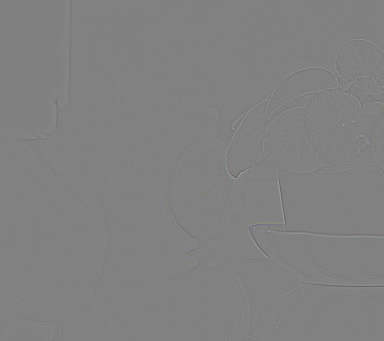

In [ ]:
scale = 0.75
violet = Image.open('violet.jpg')
violet_laplacian = MakeLaplacianPyramid(violet, scale, 350)
ShowLaplacianPyramid(violet_laplacian)

The above is the Lapacian pyramid for 'violet.jpg'.

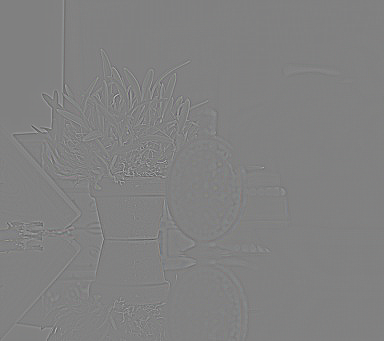

In [ ]:
orchid = Image.open('orchid.jpg')
orchid_laplacian = MakeLaplacianPyramid(orchid, scale, 350)
ShowLaplacianPyramid(orchid_laplacian)

The above is the Lapacian pyramid for 'orchid.jpg'.

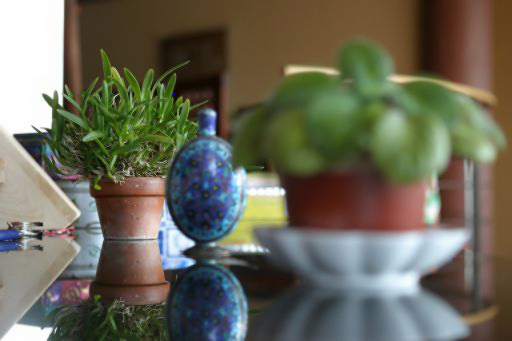

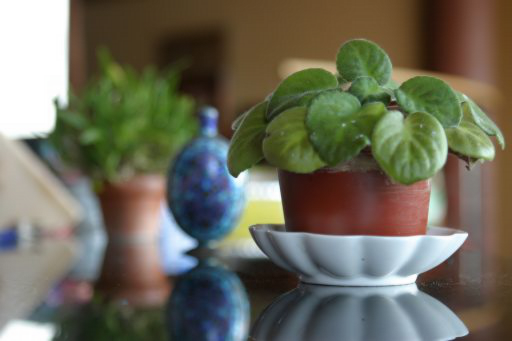

In [ ]:
def ReconstructGaussianFromLaplacianPyramid(pyr):
    newArr = [] # initialize a new empty array
    newArr.append(pyr[-1]) # append to the array
    for lapl in range(len(pyr)-2, -1, -1): # resize and save the result as an array in the below line
        changeSize = np.asarray((Image.fromarray(newArr[0])).resize((pyr[lapl].shape[1], pyr[lapl].shape[0]), Image.BICUBIC))
        numpyZeros = np.zeros(changeSize.shape) # use the result above to generate a numpy array of zeros
        for toFilter in range(0, changeSize.shape[2]): # apply the Gaussian filter to the separated channels
            numpyZeros[:,:,toFilter] = ndimage.gaussian_filter(changeSize[:,:,toFilter], 1/(2*((pyr[0].shape[0])**(-1)*(pyr[1].shape[0]))))  
        newArr.insert(0, (numpyZeros + pyr[lapl])) # insert into the array (newArr)
    return newArr # return the updated array

reconstructedTest = ReconstructGaussianFromLaplacianPyramid(orchid_laplacian) # testing my function
display(Image.fromarray(reconstructedTest[0].astype('uint8'))) # displaying the image result
Image.fromarray(np.clip(reconstructedTest[0], 0., 255).astype('uint8')).save('orchidFromLapl.png', 'png') # saving the image

reconstructedTest = ReconstructGaussianFromLaplacianPyramid(violet_laplacian) # testing my function
display(Image.fromarray(reconstructedTest[0].astype('uint8'))) # displaying the image result
Image.fromarray(np.clip(reconstructedTest[0], 0., 255).astype('uint8')).save('violetFromLapl.png', 'png') # saving the image


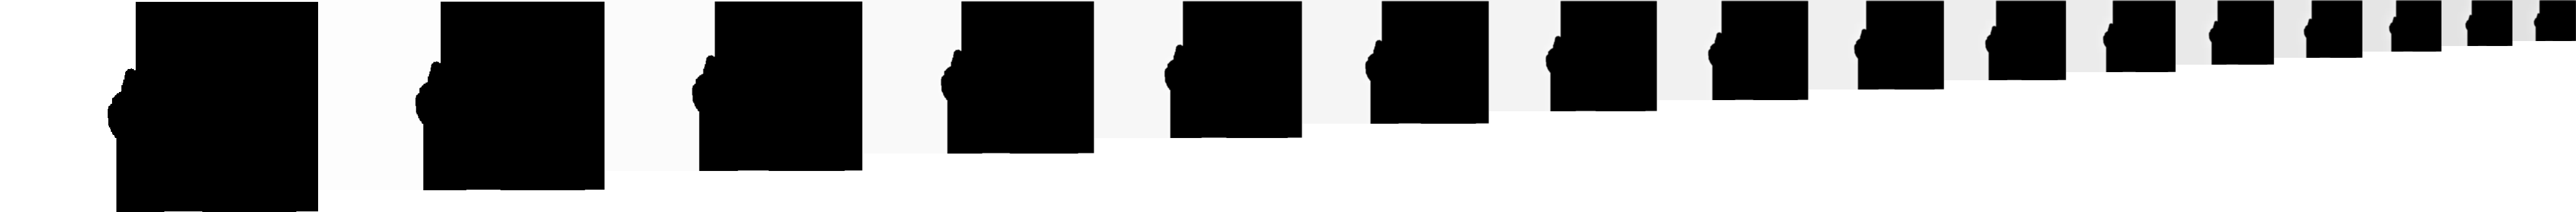

In [ ]:
orchid_mask = Image.open('orchid_mask.bmp')
orchid_mask_gausspy = MakeGaussianPyramid(orchid_mask, 0.9, 100)
ShowGaussianPyramid(orchid_mask_gausspy)

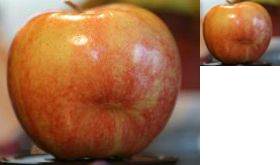

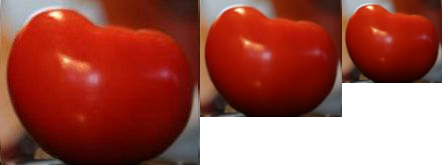

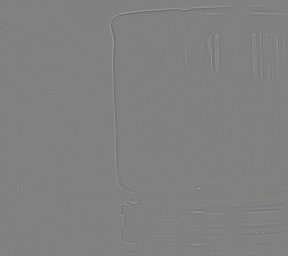

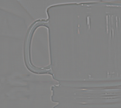

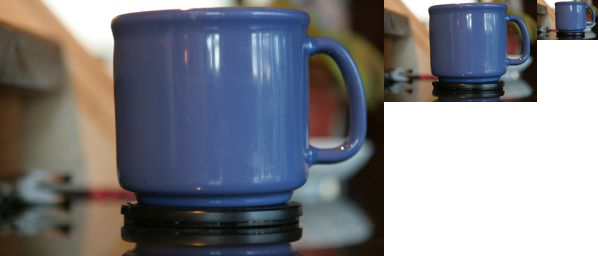

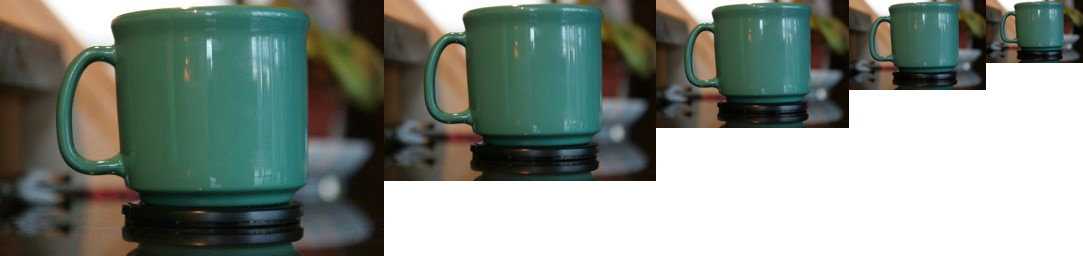

In [ ]:
apple = Image.open('apple.jpg')
apple_gausspy = MakeGaussianPyramid(apple, 0.4, 60)
ShowGaussianPyramid(apple_gausspy)

tomato = Image.open('tomato.jpg')
tomato_gausspy = MakeGaussianPyramid(tomato, 0.71, 90)
ShowGaussianPyramid(tomato_gausspy)

scale = 0.5
blue_cup = Image.open('blue_cup.jpg')
blue_cup_laplacian = MakeLaplacianPyramid(blue_cup, scale, 220)
ShowLaplacianPyramid(blue_cup_laplacian)

scale = 0.89
green_cup = Image.open('green_cup.jpg')
green_cup_laplacian = MakeLaplacianPyramid(green_cup, scale, 110)
ShowLaplacianPyramid(green_cup_laplacian)

blue_cup = Image.open('blue_cup.jpg')
blue_cup_gausspy = MakeGaussianPyramid(blue_cup, 0.4, 60)
ShowGaussianPyramid(blue_cup_gausspy)

green_cup = Image.open('green_cup.jpg')
green_cup_gausspy = MakeGaussianPyramid(green_cup, 0.71, 90)
ShowGaussianPyramid(green_cup_gausspy)